# 8) Tuning XGBoost - 2nd attempt

## Importing Packages and loading into DF

In [1]:
from __future__ import print_function
import timeit

from sklearn.model_selection import learning_curve, ShuffleSplit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import sklearn.ensemble
import xgboost as xgb

# from imblearn.over_sampling import SMOTE

from sklearn.metrics import log_loss

import lime
import lime.lime_tabular

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
ins_data = './dataset/train.csv'
ins = pd.read_csv(ins_data)
# ins_test_data = './dataset/test.csv'
# ins_test = pd.read_csv(ins_test_data)

In [3]:
print(ins.shape)
# print(ins_test.shape)

(59381, 128)


# Cleaing Data
- Dropping Axis Column
- Creating dummy for column Product_Info_2 column
- Removing NaN values - where normally distributed, replacing with mean value, where other columns used meadian.

In [4]:
ins.drop('Id',axis=1,inplace=True)
# ins_test.drop('Id',axis=1,inplace=True)

In [5]:
ins.Product_Info_2.value_counts()
prod_2 = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'A6':6,'A7':7,'A8':8,'B1':9,'B2':10,'C1':11,'C2':12,
          'C3':13,'C4':14,'D1':15,'D2':16,'D3':17,'D4':18,'E1':19}

ins.replace({"Product_Info_2": prod_2},inplace=True)

In [6]:
for i in range(2,6):
    ins['Family_Hist_%i' % i].fillna(0,inplace=True)
#     ins_test['Family_Hist_%i' % i].fillna(0,inplace=True)

for i in [1,10,15,24,32]:
    ins['Medical_History_%i' % i].fillna(0,inplace=True)
#     ins_test['Medical_History_%i' % i].fillna(0,inplace=True)

for i in [1,4,6]:
    ins['Employment_Info_%i' % i].fillna(0,inplace=True)
#     ins_test['Employment_Info_%i' % i].fillna(0,inplace=True)

ins['Insurance_History_5'].fillna(0,inplace=True)
# ins_test['Insurance_History_5'].fillna(0,inplace=True)

In [7]:
ins.shape

(59381, 127)

### Creating X and y for modelling

In [8]:
ins.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,17,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,0.0000,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,0.000000,0.598039,0.000000,0.526786,4.0,112,2,1,1,3,2,2,1,0.0,3,2,3,3,240.0,3,3,1,1,2,1,2,3,0.0,1,3,3,1,3,2,3,0.0,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,1,1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,0.000000,0.084507,0.000000,5.0,412,2,1,1,3,2,2,1,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,1,3,3,1,3,2,3,0.0,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,1,19,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,0.000000,3,2,3,3,0.304348,0.000000,0.225352,0.000000,10.0,3,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,2,2,3,1,3,2,3,0.0,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,1,18,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,0.000000,3,2,3,3,0.420290,0.000000,0.352113,0.000000,0.0,350,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,2,2,3,0.0,1,3,3,1,3,2,3,0.0,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,1,16,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,0.000000,3,2,3,2,0.463768,0.000000,0.408451,0.000000,0.0,162,2,2,1,3,2,2,2,0.0,3,2,3,3,0.0,1,3,1,1,2,1,2,3,0.0,2,2,3,1,3,2,3,0.0,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [12]:
features = ins.drop(['Response','Ht','Wt'],axis=1)
targets = ins.Response
targets = targets.map(lambda x: x-1)
X, X_holdout, y, y_holdout = train_test_split(features,targets, train_size = 0.8,test_size=0.2,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.9,test_size=0.1,random_state=50)

In [13]:
print(X_train.shape)

(42753, 124)


In [14]:
int_col_num= []
int_col_name= []
flt_col_name = []
for i in range(0,len(X_train.columns)):
    if str(X_train.dtypes[i]) == 'int64':
        int_col_num.append(int(i))
        int_col_name.append(X_train.columns[i])
    else:
        flt_col_name.append(X_train.columns[i])

In [11]:
i=1
for n in flt_col_name:
    plt.figure(i)
    sns.distplot(ins[n])
    i += 1

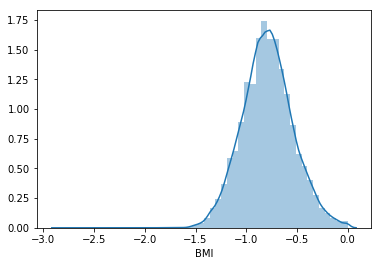

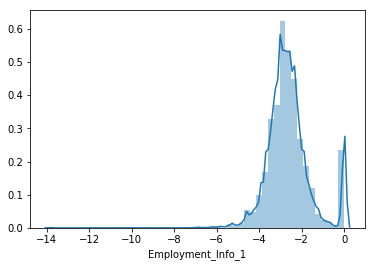

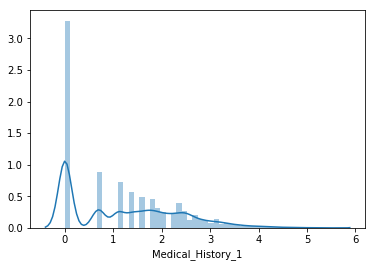

In [28]:
i=1

for n in ['BMI', 'Employment_Info_1']:
    ins[n] = ins[n].apply(lambda x: np.log(x) if x !=0 else x)
    plt.figure(i)
    sns.distplot(ins[n])
    i += 1

#### Determining Baseline

In [15]:
y_train.value_counts()

7    14053
5     8107
6     5828
1     4709
0     4396
4     3894
3     1049
2      717
Name: Response, dtype: int64

In [16]:
baseline=15637/len(y_train)
print(baseline)

0.36575211096297333


### XGBoost

In [17]:
from xgboost import XGBClassifier

In [18]:
## a more generous learning rate and using fairly default parameters. Trying to work ou the best number of estimators.
model = XGBClassifier(learning_rate=0.1,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                      objective= 'multi:softprob',scale_pos_weight=1,seed=50,early_stopping_rounds=50)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.491778	validation_0-mlogloss:1.98193	validation_1-merror:0.493791	validation_1-mlogloss:1.98287
[1]	validation_0-merror:0.453161	validation_0-mlogloss:1.89334	validation_1-merror:0.453589	validation_1-mlogloss:1.8945
[2]	validation_0-merror:0.449746	validation_0-mlogloss:1.82579	validation_1-merror:0.447906	validation_1-mlogloss:1.8274
[3]	validation_0-merror:0.444834	validation_0-mlogloss:1.77	validation_1-merror:0.443696	validation_1-mlogloss:1.7728
[4]	validation_0-merror:0.439735	validation_0-mlogloss:1.7193	validation_1-merror:0.435908	validation_1-mlogloss:1.72353
[5]	validation_0-merror:0.438917	validation_0-mlogloss:1.67627	validation_1-merror:0.435066	validation_1-mlogloss:1.68201
[6]	validation_0-merror:0.437677	validation_0-mlogloss:1.63373	validation_1-merror:0.433593	validation_1-mlogloss:1.64048
[7]	validation_0-merror:0.436016	validation_0-mlogloss:1.59694	validation_1-merror:0.43233	validation_1-mlogloss:1.60496
[8]	validation_0-merror:0.435385

[67]	validation_0-merror:0.398311	validation_0-mlogloss:1.14861	validation_1-merror:0.421806	validation_1-mlogloss:1.21873
[68]	validation_0-merror:0.398007	validation_0-mlogloss:1.14668	validation_1-merror:0.420754	validation_1-mlogloss:1.21792
[69]	validation_0-merror:0.397469	validation_0-mlogloss:1.14471	validation_1-merror:0.421174	validation_1-mlogloss:1.21696
[70]	validation_0-merror:0.396908	validation_0-mlogloss:1.14296	validation_1-merror:0.422227	validation_1-mlogloss:1.21624
[71]	validation_0-merror:0.39644	validation_0-mlogloss:1.14113	validation_1-merror:0.422437	validation_1-mlogloss:1.21543
[72]	validation_0-merror:0.395996	validation_0-mlogloss:1.13928	validation_1-merror:0.422227	validation_1-mlogloss:1.21469
[73]	validation_0-merror:0.395551	validation_0-mlogloss:1.13785	validation_1-merror:0.422227	validation_1-mlogloss:1.21431
[74]	validation_0-merror:0.395247	validation_0-mlogloss:1.13578	validation_1-merror:0.422648	validation_1-mlogloss:1.21341
[75]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, early_stopping_rounds=50,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=50, silent=None,
       subsample=0.8, verbosity=1)

In [20]:
## now that we know the best number for n_parameters, we look at max_depth and min_child_weight in a grid search.
## These 2 parameters have the most significant impact on the model.
parameters = {'max_depth':range(3,10,1),'min_child_weight':range(1,6,1)}

In [21]:
model = XGBClassifier(learning_rate=0.1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'multi:softprob',scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search = GridSearchCV(model,param_grid=parameters,cv=5,n_jobs=-1)
grid_search.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=99, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(3, 10), 'min_child_weight': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 6, 'min_child_weight': 5}, 0.5518838139339086)

In [23]:
## Now we test gamma
parameters2 = {'gamma':[i/10.0 for i in range(3,10,1)]}
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,
                                                  subsample=0.8,colsample_bytree=0.8,objective= 'multi:softprob',
                                                  scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search2 = GridSearchCV(model,param_grid=parameters2,cv=5,n_jobs=-1)
grid_search2.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=99, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
grid_search2.best_params_, grid_search2.best_score_

({'gamma': 0.4}, 0.5533571879604294)

In [29]:
## double checking if n_estimators now need to be updated
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,subsample=0.8,colsample_bytree=0.8,objective= 'multi:softprob',scale_pos_weight=1,seed=27,early_stopping_rounds=40)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.449138	validation_0-mlogloss:1.96643	validation_1-merror:0.45422	validation_1-mlogloss:1.96914
[1]	validation_0-merror:0.438917	validation_0-mlogloss:1.88253	validation_1-merror:0.447064	validation_1-mlogloss:1.88674
[2]	validation_0-merror:0.434168	validation_0-mlogloss:1.81624	validation_1-merror:0.440749	validation_1-mlogloss:1.8224
[3]	validation_0-merror:0.432554	validation_0-mlogloss:1.75092	validation_1-merror:0.439907	validation_1-mlogloss:1.75757
[4]	validation_0-merror:0.430683	validation_0-mlogloss:1.69601	validation_1-merror:0.438224	validation_1-mlogloss:1.70471
[5]	validation_0-merror:0.428578	validation_0-mlogloss:1.64736	validation_1-merror:0.436329	validation_1-mlogloss:1.65769
[6]	validation_0-merror:0.428414	validation_0-mlogloss:1.60702	validation_1-merror:0.438013	validation_1-mlogloss:1.61853
[7]	validation_0-merror:0.426005	validation_0-mlogloss:1.5706	validation_1-merror:0.432751	validation_1-mlogloss:1.58405
[8]	validation_0-merror:0.4

[67]	validation_0-merror:0.37995	validation_0-mlogloss:1.1037	validation_1-merror:0.422016	validation_1-mlogloss:1.20334
[68]	validation_0-merror:0.379459	validation_0-mlogloss:1.10181	validation_1-merror:0.422227	validation_1-mlogloss:1.20279
[69]	validation_0-merror:0.379084	validation_0-mlogloss:1.10005	validation_1-merror:0.422648	validation_1-mlogloss:1.202
[70]	validation_0-merror:0.378617	validation_0-mlogloss:1.09791	validation_1-merror:0.422437	validation_1-mlogloss:1.20154
[71]	validation_0-merror:0.378196	validation_0-mlogloss:1.09618	validation_1-merror:0.422227	validation_1-mlogloss:1.20069
[72]	validation_0-merror:0.377073	validation_0-mlogloss:1.09395	validation_1-merror:0.421595	validation_1-mlogloss:1.19995
[73]	validation_0-merror:0.376652	validation_0-mlogloss:1.09225	validation_1-merror:0.422437	validation_1-mlogloss:1.19905
[74]	validation_0-merror:0.376114	validation_0-mlogloss:1.09088	validation_1-merror:0.423279	validation_1-mlogloss:1.19873
[75]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, early_stopping_rounds=40,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

In [27]:
parameters3 = {'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}

model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,
                                                  objective= 'multi:softprob',
                                                  scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search3 = GridSearchCV(model,param_grid=parameters3,cv=5,n_jobs=-1)
grid_search3.fit(X_test,y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=99, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
grid_search3.best_params_, grid_search3.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.5527257419490633)

In [31]:
## checking colsample_bytree and subsample more granularly
parameters4 = {'subsample':[i/100.0 for i in range(65,80,5)],'colsample_bytree':[i/100.0 for i in range(80,100,5)]}
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,
                                                  objective= 'multi:softprob',
                                                  scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search4 = GridSearchCV(model,param_grid=parameters4,cv=5,n_jobs=-1)
grid_search4.fit(X_test,y_test)
grid_search4.best_params_, grid_search4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.75}, 0.5491475478846558)

In [32]:
parameters5 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.8,subsample=0.75,
                                                  objective= 'multi:softprob',
                                                  scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search5 = GridSearchCV(model,param_grid=parameters5,cv=5,n_jobs=-1)
grid_search5.fit(X_test,y_test)
grid_search5.best_params_, grid_search5.best_score_

({'reg_alpha': 0.1}, 0.5501999579035992)

In [33]:
parameters6 = {'learning_rate':[0.001,0.002,0.005]}
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.8,subsample=0.75,
                                                  objective= 'multi:softprob',reg_alpha=0.1,
                                                  scale_pos_weight=1,seed=27,n_estimators=99) 
grid_search6 = GridSearchCV(model,param_grid=parameters6,cv=5,n_jobs=-1)
grid_search6.fit(X_test,y_test)
grid_search6.best_params_, grid_search6.best_score_

({'learning_rate': 0.005}, 0.5453588718164597)

In [34]:
model = XGBClassifier(learning_rate=0.005,max_depth=6,min_child_weight=4,gamma=0.4,colsample_bytree=0.8,subsample=0.75,
                                                  objective= 'multi:softprob',reg_alpha=0.1,
                                                  scale_pos_weight=1,seed=27,n_estimators=99)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train,eval_metric=['merror','mlogloss'],eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.449489	validation_0-mlogloss:2.07364	validation_1-merror:0.454852	validation_1-mlogloss:2.07377
[1]	validation_0-merror:0.437537	validation_0-mlogloss:2.06822	validation_1-merror:0.447274	validation_1-mlogloss:2.06844
[2]	validation_0-merror:0.438846	validation_0-mlogloss:2.06338	validation_1-merror:0.443907	validation_1-mlogloss:2.0637
[3]	validation_0-merror:0.438075	validation_0-mlogloss:2.05767	validation_1-merror:0.440749	validation_1-mlogloss:2.05804
[4]	validation_0-merror:0.437232	validation_0-mlogloss:2.05215	validation_1-merror:0.439907	validation_1-mlogloss:2.0526
[5]	validation_0-merror:0.435993	validation_0-mlogloss:2.04664	validation_1-merror:0.439486	validation_1-mlogloss:2.04719
[6]	validation_0-merror:0.435244	validation_0-mlogloss:2.04144	validation_1-merror:0.439697	validation_1-mlogloss:2.04208
[7]	validation_0-merror:0.434005	validation_0-mlogloss:2.03656	validation_1-merror:0.439276	validation_1-mlogloss:2.03732
[8]	validation_0-merror:0.

[67]	validation_0-merror:0.426309	validation_0-mlogloss:1.80321	validation_1-merror:0.434014	validation_1-mlogloss:1.80942
[68]	validation_0-merror:0.426146	validation_0-mlogloss:1.80025	validation_1-merror:0.433382	validation_1-mlogloss:1.80651
[69]	validation_0-merror:0.426286	validation_0-mlogloss:1.79759	validation_1-merror:0.433803	validation_1-mlogloss:1.80391
[70]	validation_0-merror:0.426005	validation_0-mlogloss:1.7949	validation_1-merror:0.432751	validation_1-mlogloss:1.80129
[71]	validation_0-merror:0.425678	validation_0-mlogloss:1.79235	validation_1-merror:0.432541	validation_1-mlogloss:1.79879
[72]	validation_0-merror:0.425958	validation_0-mlogloss:1.78935	validation_1-merror:0.432541	validation_1-mlogloss:1.79593
[73]	validation_0-merror:0.425841	validation_0-mlogloss:1.78632	validation_1-merror:0.43212	validation_1-mlogloss:1.79297
[74]	validation_0-merror:0.425678	validation_0-mlogloss:1.78325	validation_1-merror:0.431909	validation_1-mlogloss:1.79001
[75]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
       learning_rate=0.005, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=99, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.75, verbosity=1)

In [36]:
## calculate accuracy
accuracy_score_test = model.score(X_test,y_test)
accuracy_score_train = model.score(X_train,y_train)
## calculate log loss
y_pred = model.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)
y_pred = model.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)
## print values
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

-------------------------------
accuracy score - train:  0.5752812668116857
accuracy score - test:  0.5691433382445801
-------------------------------
log loss score - train:  1.719087940328869
log loss score - test:  1.7278694607689113


In [47]:
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=0.4,subsample=0.75,colsample_bytree=0.8,
                      objective= 'multi:softprob',reg_alpha=0.1,reg_lambda=5,scale_pos_weight=1,seed=27)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,y_train,eval_metric=['mlogloss'],eval_set=eval_set, verbose=True)
accuracy_score_test = model.score(X_test,y_test)
accuracy_score_train = model.score(X_train,y_train)
## calculate log loss
y_pred = model.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)
y_pred = model.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)
## print values
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

[0]	validation_0-mlogloss:1.96878	validation_1-mlogloss:1.97064
[1]	validation_0-mlogloss:1.88622	validation_1-mlogloss:1.88966
[2]	validation_0-mlogloss:1.82123	validation_1-mlogloss:1.8263
[3]	validation_0-mlogloss:1.75693	validation_1-mlogloss:1.76252
[4]	validation_0-mlogloss:1.70289	validation_1-mlogloss:1.70967
[5]	validation_0-mlogloss:1.65527	validation_1-mlogloss:1.66323
[6]	validation_0-mlogloss:1.61533	validation_1-mlogloss:1.62444
[7]	validation_0-mlogloss:1.5796	validation_1-mlogloss:1.59036
[8]	validation_0-mlogloss:1.54513	validation_1-mlogloss:1.55728
[9]	validation_0-mlogloss:1.51638	validation_1-mlogloss:1.52958
[10]	validation_0-mlogloss:1.49115	validation_1-mlogloss:1.5053
[11]	validation_0-mlogloss:1.46622	validation_1-mlogloss:1.48192
[12]	validation_0-mlogloss:1.4459	validation_1-mlogloss:1.46231
[13]	validation_0-mlogloss:1.42812	validation_1-mlogloss:1.44571
[14]	validation_0-mlogloss:1.40927	validation_1-mlogloss:1.42827
[15]	validation_0-mlogloss:1.39162	vali

In [40]:
accuracy_score_holdout = model.score(X_holdout,y_holdout)
## calculate log loss
y_pred = model.predict_proba(X_holdout)
log_loss_holdout = log_loss(y_holdout,y_pred)
## print values
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_holdout)
print('-------------------------------')
print("log loss score - train: ",log_loss_holdout)

-------------------------------
accuracy score - train:  0.5791866632988129
-------------------------------
log loss score - train:  1.1862075663227931


In [49]:
model = XGBClassifier(learning_rate=0.1,max_depth=6,min_child_weight=5,gamma=1.2,subsample=0.75,colsample_bytree=0.8,
                      objective= 'multi:softprob',reg_alpha=2,scale_pos_weight=1,seed=27,reg_lambda=10)

model.fit(X_train,y_train)
accuracy_score_test = model.score(X_test,y_test)
accuracy_score_train = model.score(X_train,y_train)

## calculate log loss
y_pred = model.predict_proba(X_train)
log_loss_train = log_loss(y_train,y_pred)
y_pred = model.predict_proba(X_test)
log_loss_test = log_loss(y_test,y_pred)

## print values
print('-------------------------------')
print("accuracy score - train: ",accuracy_score_train)
print("accuracy score - test: ",accuracy_score_test)
print('-------------------------------')
print("log loss score - train: ",log_loss_train)
print("log loss score - test: ",log_loss_test)

-------------------------------
accuracy score - train:  0.612401468902767
accuracy score - test:  0.5809303304567459
-------------------------------
log loss score - train:  1.107930940374158
log loss score - test:  1.194136337487102
